<font size="6"> Machine Learning na Segurança do Trabalho</font>

<font size="4"> Prevendo a Eficiência de Extintores de Incêndio</font>

# Business Understanding

# Packages

In [1]:
library(readxl)        # read Excel files
library(dplyr)         # for data manipulation and transformation
library(ggplot2)       # create graphics
library(gridExtra)     # organize graphics in a grid format
library(GGally)        # creating graphical displays of pairwise relationships in data
library(tidyverse)     # for data manipulation and transformation
library(caret)         # training and evaluating machine learning models
library(naivebayes)    # implementing the Naive Bayes algorithm
library(rpart)         # implementing the Decision Trees algorithm
library(Metrics)       # evaluating model performance metrics
library(e1071)         # implementing the Support Vector MAchines algorithm
library(randomForest)  # implementing the Random Forest algorithm
library(kernlab)       # for kernel-based machine learning algorithms  


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ gridExtra::combine() masks dplyr::combine()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::lag()         masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


naivebayes 0.9.7 loaded


Attaching package: ‘Metrics’


The following objects a

# Data Understanding

## Loading Data

In [2]:
df_raw <- read_excel("data/Acoustic_Extinguisher_Fire_Dataset.xlsx")

In [3]:
head(df_raw)

SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,gasoline,10,96,0.0,75,0
1,gasoline,10,96,0.0,72,1
1,gasoline,10,96,2.6,70,1
1,gasoline,10,96,3.2,68,1
1,gasoline,10,109,4.5,67,1
1,gasoline,10,109,7.8,66,1


## Data Dimensions

In [4]:
d <- dim(df_raw)

In [5]:
print(paste("Number of rows:",d[1],"|", "Number of columns:", d[2]))

[1] "Number of rows: 17442 | Number of columns: 7"


## Check NA

In [6]:
print(paste("Number of NA:",sum(is.na(df_raw))))

[1] "Number of NA: 0"


## Data Types

In [7]:
str(df_raw)

tibble [17,442 × 7] (S3: tbl_df/tbl/data.frame)
 $ SIZE     : num [1:17442] 1 1 1 1 1 1 1 1 1 1 ...
 $ FUEL     : chr [1:17442] "gasoline" "gasoline" "gasoline" "gasoline" ...
 $ DISTANCE : num [1:17442] 10 10 10 10 10 10 10 10 10 10 ...
 $ DESIBEL  : num [1:17442] 96 96 96 96 109 109 103 95 102 93 ...
 $ AIRFLOW  : num [1:17442] 0 0 2.6 3.2 4.5 7.8 9.7 12 13.3 15.4 ...
 $ FREQUENCY: num [1:17442] 75 72 70 68 67 66 65 60 55 52 ...
 $ STATUS   : num [1:17442] 0 1 1 1 1 1 1 1 1 1 ...


## Change Types

In [8]:
#converting features to factors
df1 <- df_raw %>%
    mutate(FUEL     = factor(FUEL),
           STATUS   = factor(STATUS, levels = c(0,1), labels = c("Non-Extinction", "Extinction")))

## Data Summary

In [9]:
summary(df1)

      SIZE             FUEL         DISTANCE      DESIBEL      
 Min.   :1.000   gasoline:5130   Min.   : 10   Min.   : 72.00  
 1st Qu.:2.000   kerosene:5130   1st Qu.: 50   1st Qu.: 90.00  
 Median :3.000   lpg     :2052   Median :100   Median : 95.00  
 Mean   :3.412   thinner :5130   Mean   :100   Mean   : 96.38  
 3rd Qu.:5.000                   3rd Qu.:150   3rd Qu.:104.00  
 Max.   :7.000                   Max.   :190   Max.   :113.00  
    AIRFLOW         FREQUENCY                STATUS    
 Min.   : 0.000   Min.   : 1.00   Non-Extinction:8759  
 1st Qu.: 3.200   1st Qu.:14.00   Extinction    :8683  
 Median : 5.800   Median :27.50                        
 Mean   : 6.976   Mean   :31.61                        
 3rd Qu.:11.200   3rd Qu.:47.00                        
 Max.   :17.000   Max.   :75.00                        

# Feature Engineering 

In [10]:
# Transforming the values of the feature
df1 <- df1 %>%
  mutate(SIZE = case_when(
    SIZE == 1 ~ 7,
    SIZE == 2 ~ 12,
    SIZE == 3 ~ 14,
    SIZE == 4 ~ 16,
    SIZE == 5 ~ 20,
    TRUE ~ SIZE
  ))

# Exploratory Data Analysis

## Univariate Analysis

In [11]:
# Selecting only the numeric columns
df_num <- select_if(df1, is.numeric)

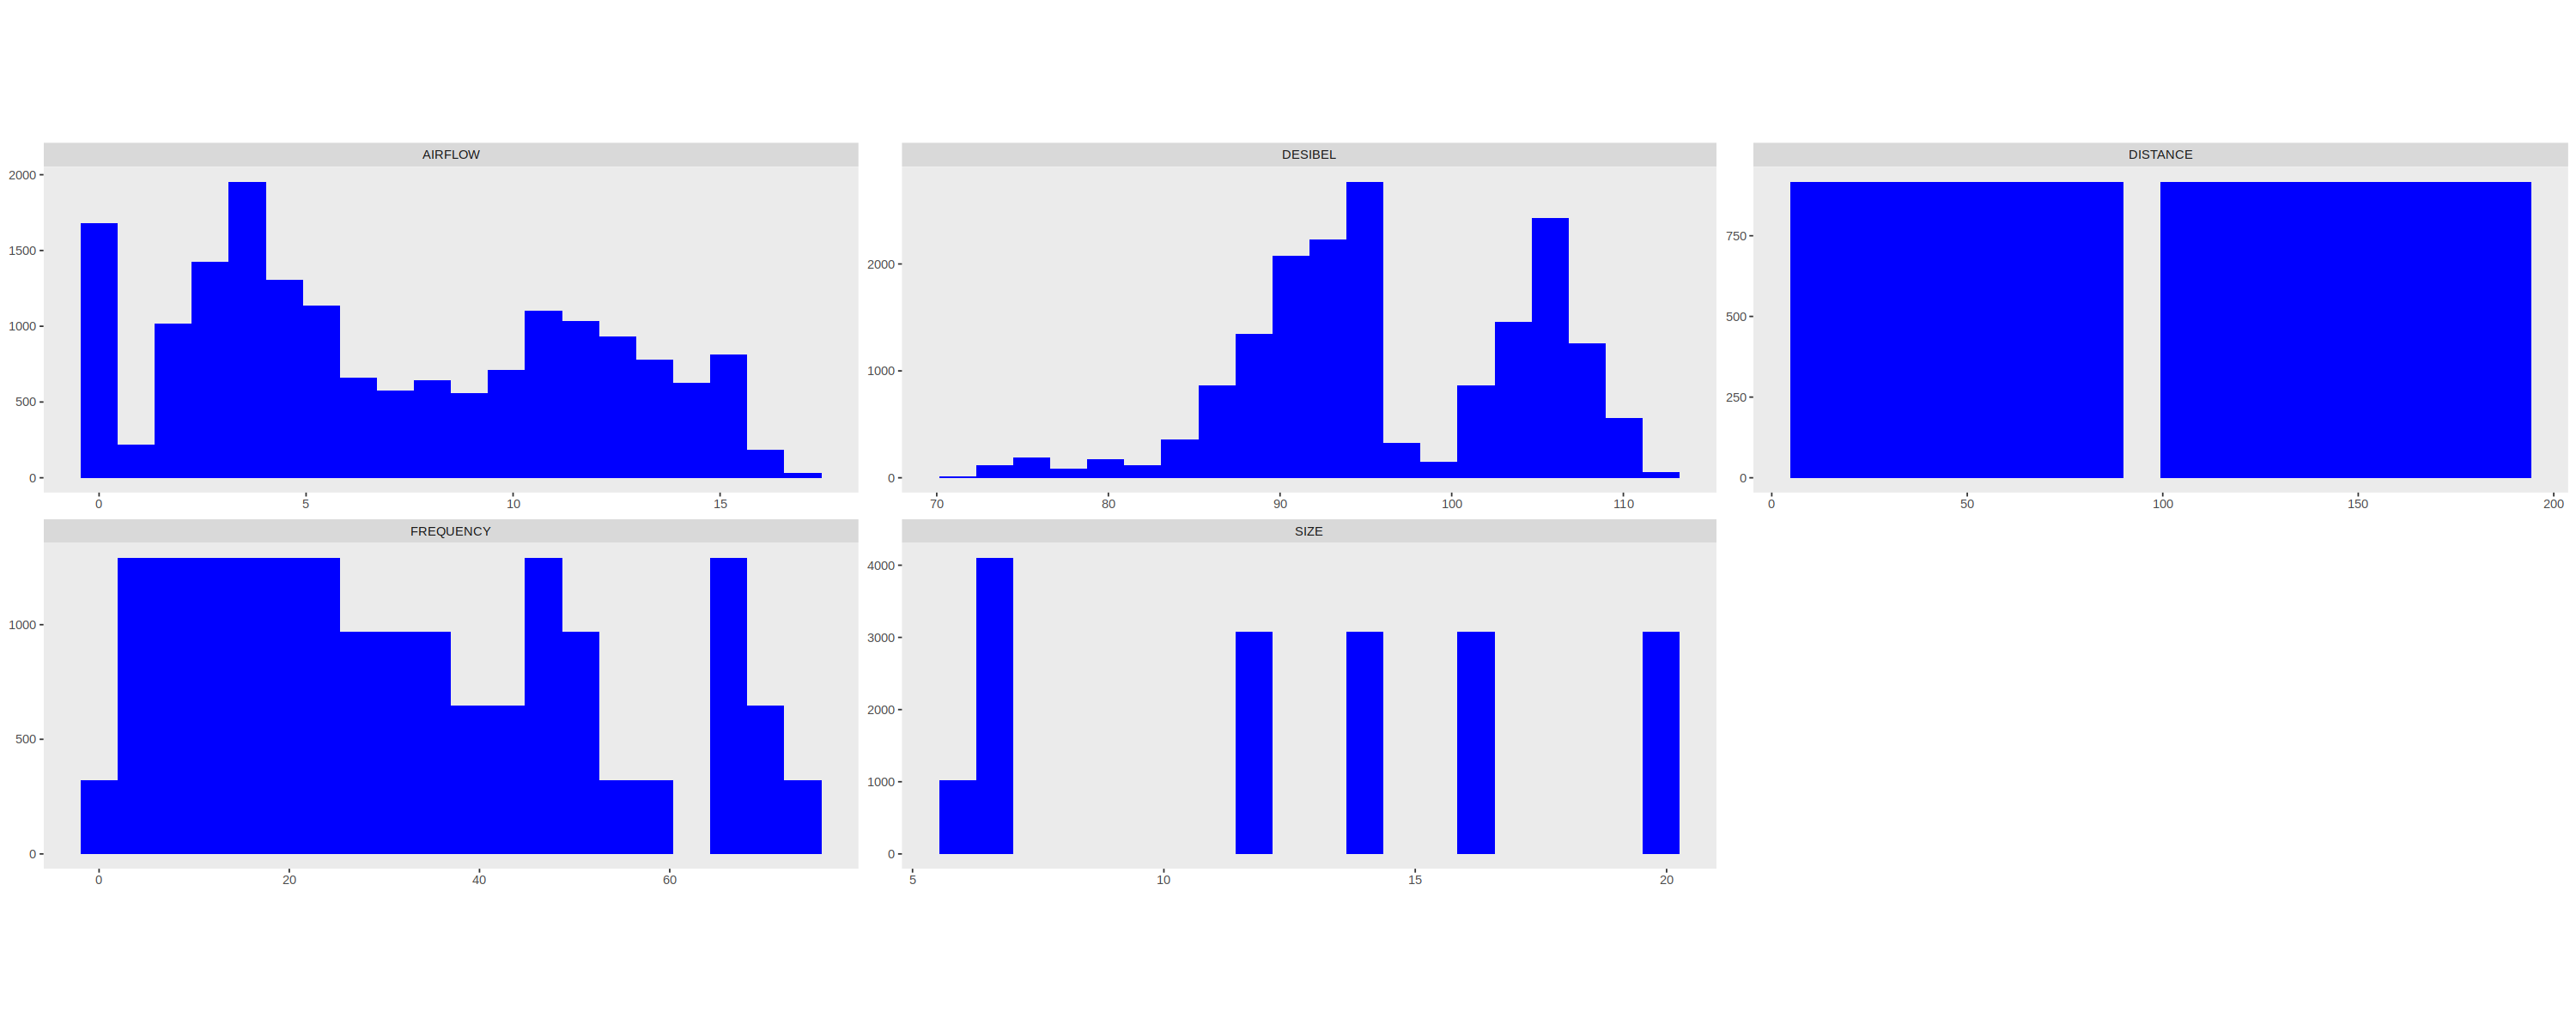

In [12]:
# histogram plot for each numeric variable
options(repr.plot.width = 25, repr.plot.height = 10)
df_num %>% 
  gather(key = Variable, value = Value) %>% 
  ggplot() +
    geom_histogram(aes(x = Value), bins = 20, fill='blue') +
    facet_wrap(~Variable, scales='free') +
    theme_grey() +
    theme(aspect.ratio = 0.4, axis.title = element_blank(),panel.grid = element_blank())

### Status (target)

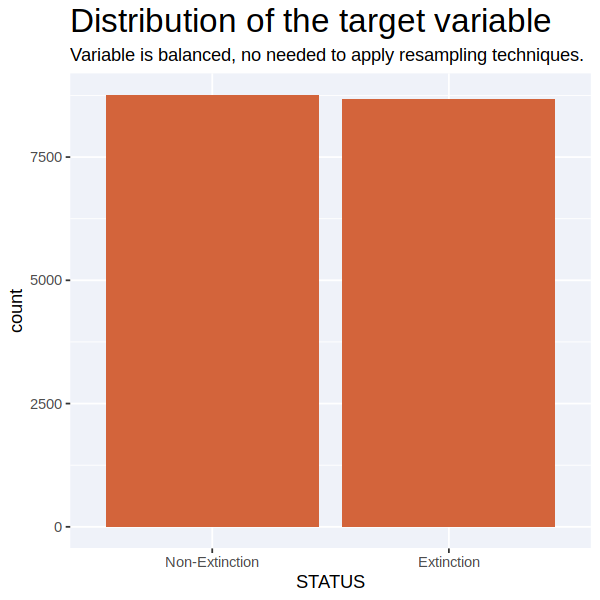

In [13]:
options(repr.plot.width = 5, repr.plot.height = 5)
ggplot(df1, aes(x = STATUS)) +
    geom_bar(stat = "count", fill = "#d3643b") +
    labs(title = "Distribution of the target variable",
         subtitle = "Variable is balanced, no needed to apply resampling techniques.") + 
    theme(plot.caption = element_text(size = 13),
         panel.background = element_rect(fill = "#eff2f9"),
         plot.title = element_text(size = 20))

In [14]:
#sizeod plot's
options(repr.plot.width = 8, repr.plot.height = 4)

In [15]:
# aux data frame
aux1 <- df1[df1$STATUS == "Extinction",]
aux2 <- df1[!df1$STATUS == "Extinction",]

### Size

The majority of successful fire extinguishments are observed across a broad range of can sizes, specifically between 7 cm and 16 cm. However, a closer examination reveals that the instances of unsuccessful fire extinguishments are predominantly concentrated within a narrower range, specifically between 12 cm and 16 cm.

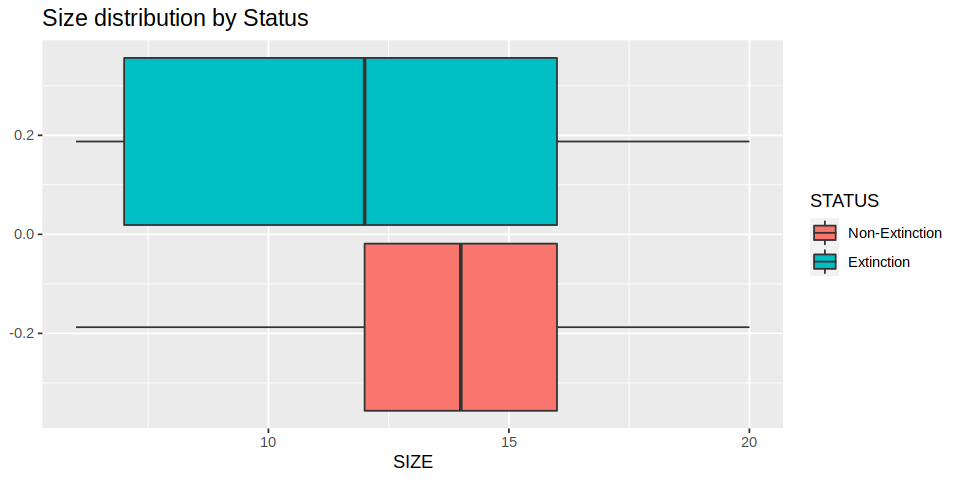

In [16]:
ggplot(df1, aes(x = SIZE, fill = STATUS))+
    geom_boxplot() +
    labs(title = "Size distribution by Status") +
    theme(plot.title = element_text(size = 14))

In [17]:
# Extinction Summary
summary(aux1$SIZE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.00    7.00   12.00   12.19   16.00   20.00 

In [18]:
# Non-Extinction Summary
summary(aux2$SIZE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   6.00   12.00   14.00   13.68   16.00   20.00 

### Distance

Distance plays a significant role in fire extinguishment. Unsuccessful extinguishments tend to occur more often at greater distances, specifically ranging from 110 cm to 170 cm. On the other hand, successful extinguishments are more frequently observed within a narrower range of distances, specifically between 30 cm and 90 cm.

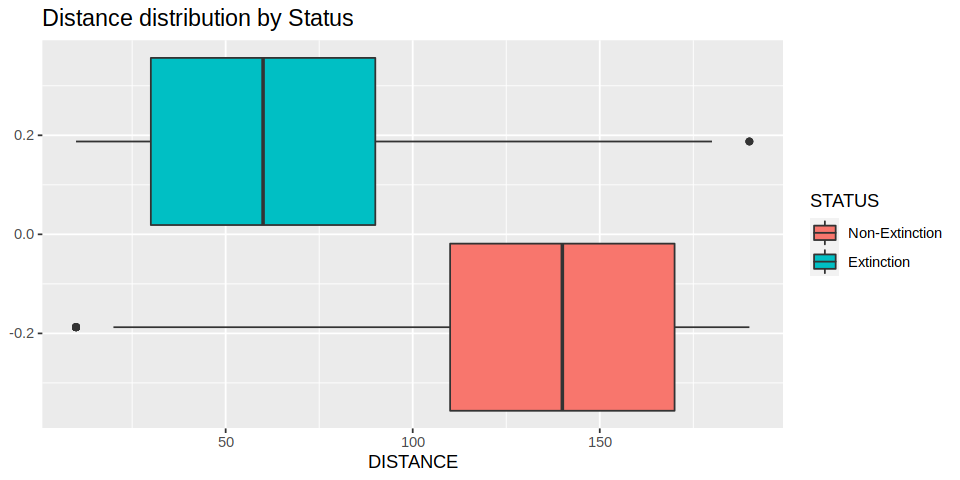

In [19]:
ggplot(df1, aes(x = DISTANCE, fill = STATUS))+
    geom_boxplot() +
    labs(title = "Distance distribution by Status") +
    theme(plot.title = element_text(size = 14))

In [20]:
# Extinction Summary
summary(aux1$DISTANCE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  10.00   30.00   60.00   64.57   90.00  190.00 

In [21]:
# Non-Extinction Summary
summary(aux2$DISTANCE)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   10.0   110.0   140.0   135.1   170.0   190.0 

### Desibel

Fire extinguishment was predominantly observed within the range of 90dB to 106dB, while non-extinguishment instances occurred within the narrower range of 91dB to 102dB. This suggests that the desible level alone was not a determining factor for the success or failure of fire extinguishment.

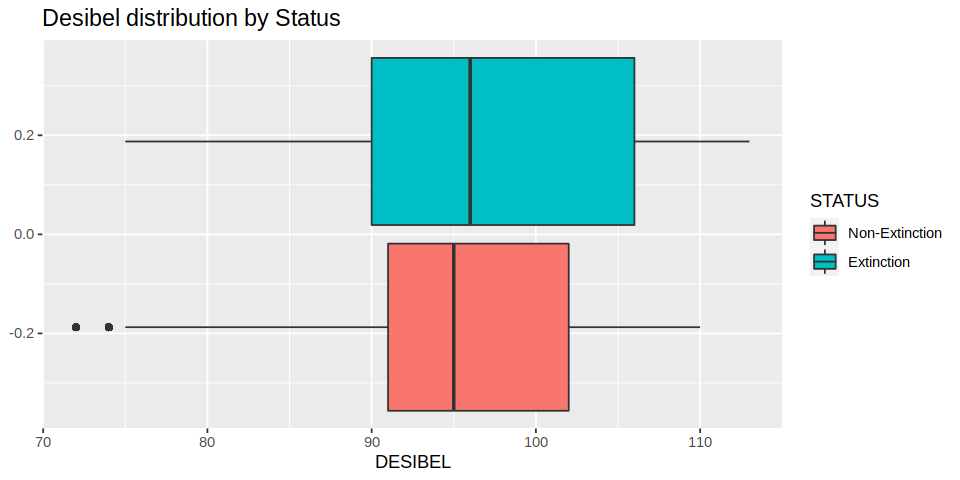

In [22]:
ggplot(df1, aes(x = DESIBEL, fill = STATUS))+
    geom_boxplot() +
    labs(title = "Desibel distribution by Status") +
    theme(plot.title = element_text(size = 14))

In [23]:
# Extinction Summary
summary(aux1$DESIBEL)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  75.00   90.00   96.00   98.05  106.00  113.00 

In [24]:
# Non-Extinction Summary
summary(aux2$DESIBEL)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  72.00   91.00   95.00   94.72  102.00  110.00 

### Airflow

Fire extinguishment was predominantly observed within the range of 8.5 m/s to 13.3 m/s, indicating the significance of airflow in the success of fire extinguishment. On the other hand, non-extinguishment instances were concentrated in the range of 1.7 m/s to 4.6 m/s, further highlighting the influence of airflow on the effectiveness of fire suppression efforts.

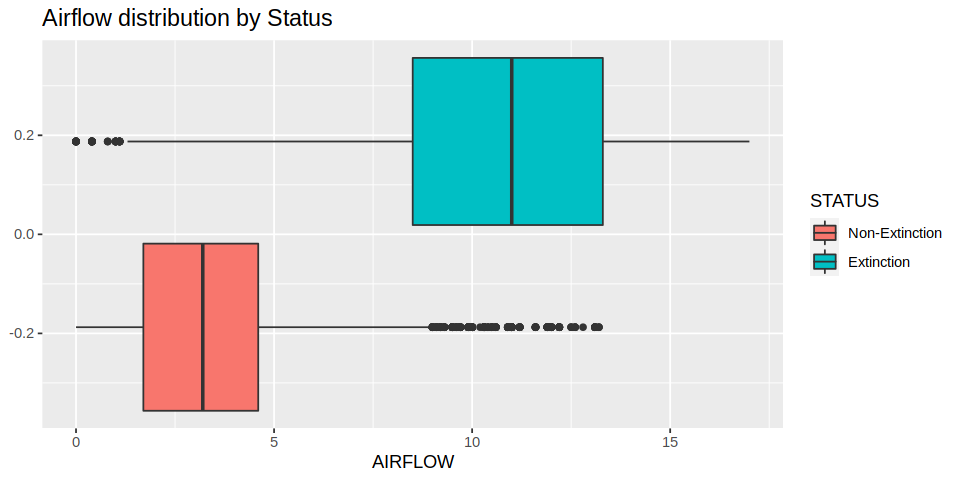

In [25]:
ggplot(df1, aes(x = AIRFLOW, fill = STATUS))+
    geom_boxplot() +
    labs(title = "Airflow distribution by Status") +
    theme(plot.title = element_text(size = 14))

In [26]:
# Extinction Summary
summary(aux1$AIRFLOW)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    8.50   11.00   10.59   13.30   17.00 

In [27]:
# Non-Extinction Summary
summary(aux2$AIRFLOW)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.700   3.200   3.389   4.600  13.200 

### Frequency

Fire extinguishment was primarily observed in the frequency range of 14Hz to 36Hz, while non-extinguishment instances were spread across a broader range of 13Hz to 60Hz. This indicates that a higher frequency alone is not a significant factor in achieving fire extinguishment.

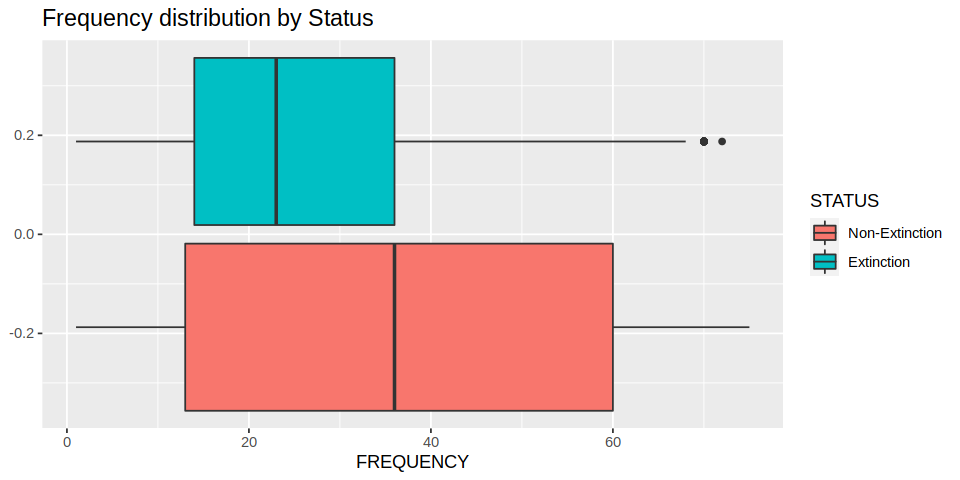

In [28]:
ggplot(df1, aes(x = FREQUENCY, fill = STATUS))+
    geom_boxplot() +
    labs(title = "Frequency distribution by Status") +
    theme(plot.title = element_text(size = 14))

In [29]:
# Extinction Summary
summary(aux1$FREQUENCY)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   14.00   23.00   26.48   36.00   72.00 

In [30]:
# Non-Extinction Summary
summary(aux2$FREQUENCY)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    13.0    36.0    36.7    60.0    75.0 

### Fuel

There were no significant differences observed in the type of fuel used between fire extinguishment and non-extinguishment instances.

In [31]:
aux_fuel <- table(df1$FUEL, df1$STATUS)
aux_fuel <- prop.table(aux_fuel, margin = 1)

aux_fuel <- as.data.frame(aux_fuel)

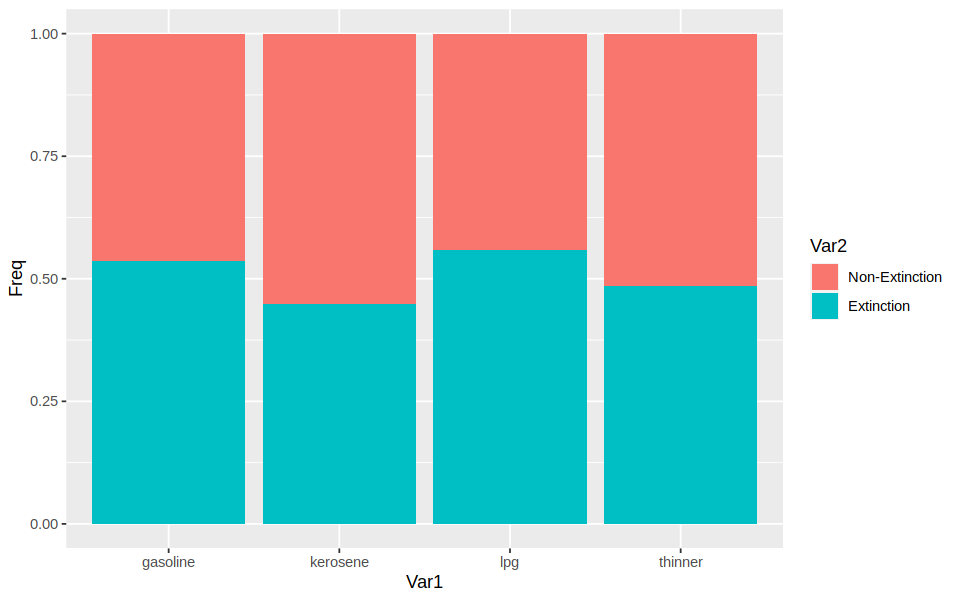

In [32]:
options(repr.plot.width = 8, repr.plot.height = 5)
ggplot(aux_fuel, aes(x=Var1, y=Freq, fill = Var2)) + 
    geom_bar(stat = "identity")

## Bivariate Analysis

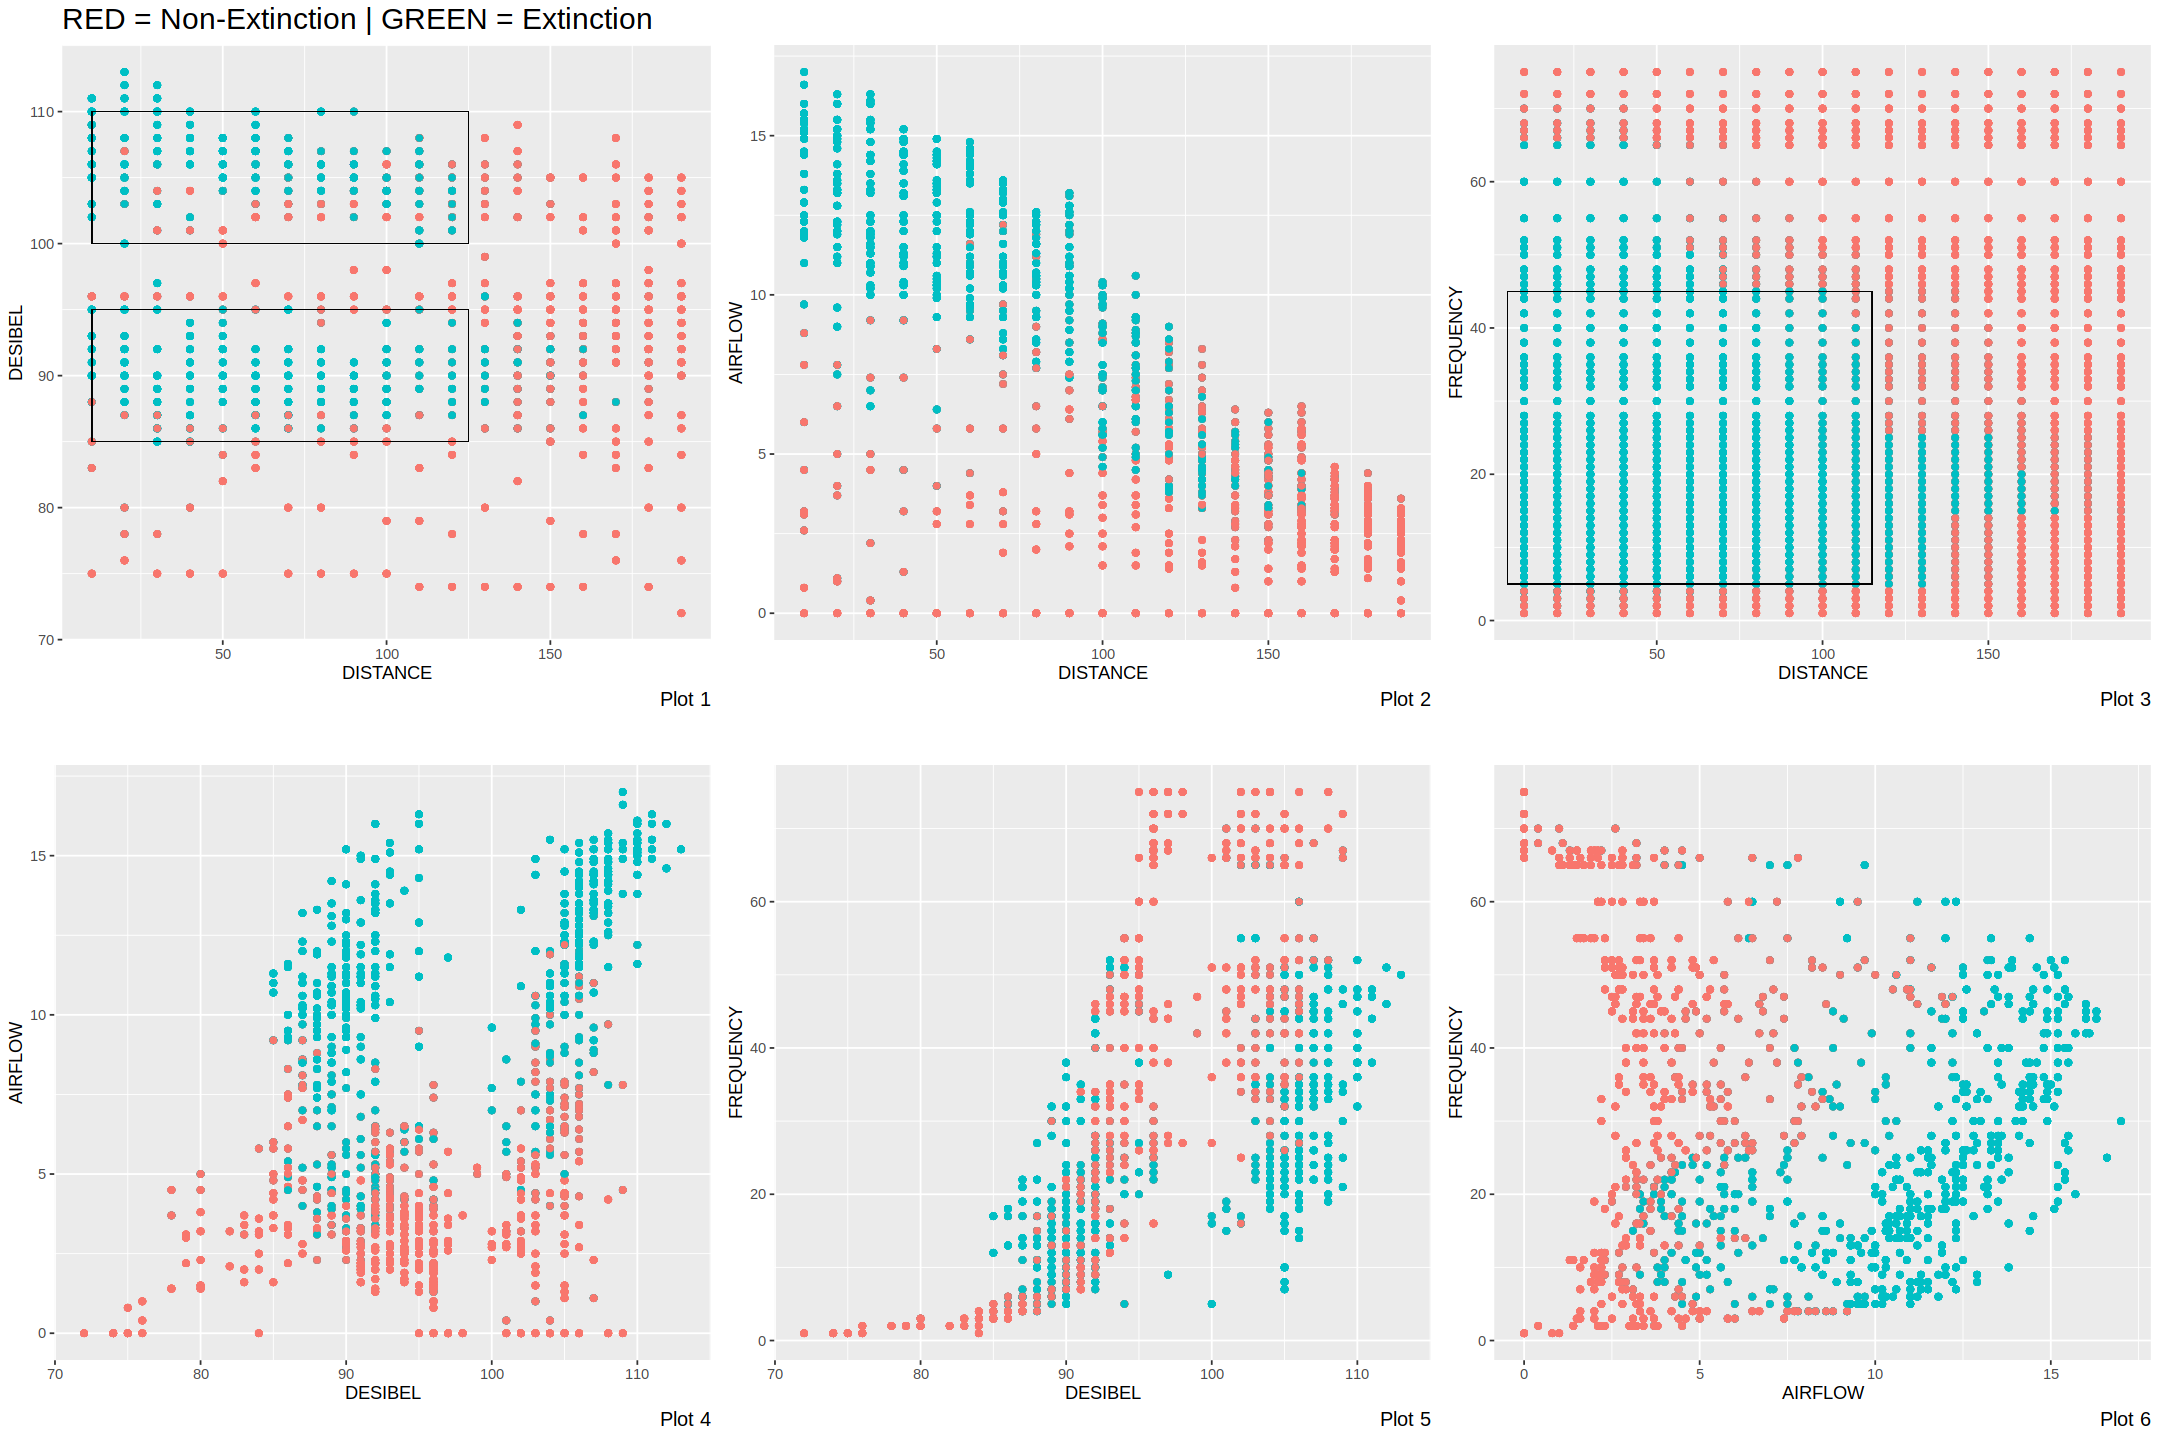

In [33]:
options(repr.plot.width = 18, repr.plot.height = 12)
p_point <- ggplot(df1) +
    labs(title = "") +
    guides(color = "none") +
    theme(plot.title = element_text(size = 18),
          plot.caption = element_text(size = 12))+
    geom_point()

p1 <- p_point + aes(x= DISTANCE, y = DESIBEL  , col = STATUS) + 
      labs(title = "RED = Non-Extinction | GREEN = Extinction", caption = "Plot 1") + 
      geom_rect(xmin = 10, xmax = 125, ymin = 100, ymax = 110, fill = NA, color = "black", size = 0.2) +
      geom_rect(xmin = 10, xmax = 125, ymin = 85, ymax = 95, fill = NA, color = "black", size = 0.2) 

p2 <- p_point + aes(x= DISTANCE, y = AIRFLOW  , col = STATUS) + labs(caption = "Plot 2")

p3 <- p_point + aes(x= DISTANCE, y = FREQUENCY, col = STATUS) + labs(caption = "Plot 3")+
    geom_rect(xmin = 5, xmax = 115, ymin = 5, ymax = 45, fill = NA, color = "black", size = 0.2) 

p4 <- p_point + aes(x= DESIBEL , y = AIRFLOW  , col = STATUS) + labs(caption = "Plot 4") 

p5 <- p_point + aes(x= DESIBEL , y = FREQUENCY, col = STATUS) + labs(caption = "Plot 5") 

p6 <- p_point + aes(x= AIRFLOW , y = FREQUENCY, col = STATUS) + labs(caption = "Plot 6") 

PlotsList<- list(p1,p2, p3,p4,p5,p6)
grid.arrange(grobs = PlotsList, ncol = 3)

**Plot 1** - Fire extinguishment shows higher effectiveness within the range of 85dB - 95dB and 105dB - 110dB at distances up to 125 cm. <p> **Plot 2** - The fire can be effectively extinguished when the airflow rate is above 5 m/s. Additionally, there is a negative correlation observed between Airflow and Distance, indicating that as the distance increases, the airflow tends to decrease. <p> **Plot 3** - Fires can be effectively extinguished within a maximum distance of 115 cm when using frequencies ranging from 5Hz to 45Hz.<p> **Plot 4** - The greatest success in fire extinguishment is achieved with an airflow above 5 m/s and decibel levels ranging from 85dB to 90dB and 100dB to 105dB.<p> **Plot 5** - There is a positive correlation between frequency and decibels. However, it is important to note that higher frequencies alone do not guarantee success in fire extinguishment. <p> **Plot 6** - This graph illustrates the significance of sufficient airflow in fire extinguishment. It is evident that successful fire extinguishment can be achieved across various frequency ranges, emphasizing the importance of airflow in the process.<p> **Summary**
In the process of fire extinguishment using acoustic extinguishers, there is a precise adjustment between frequency and airflow that ensures effective targeting of the fire location.

## Multivariate Analysis

In [34]:
df_num <- select_if(df1, is.numeric)
round(cor(df_num),2)

,SIZE,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY
SIZE,1,0.00,0.00,0.00,0.00
DISTANCE,0,1.00,-0.24,-0.71,0.00
DESIBEL,0,-0.24,1.00,0.38,0.56
AIRFLOW,0,-0.71,0.38,1.00,-0.21
FREQUENCY,0,0.00,0.56,-0.21,1.00


# Data Preparation

In [35]:
df5 <- df1

## Split Train and Test

In [36]:
# split 70% for raining and 30% for testing
set.seed = 42
index <- createDataPartition(df5$STATUS, p = 0.8, list = FALSE)
df_train <- df5[index,]
df_test  <- df5[-index,]

## Normalization

In [37]:
# Normalizando os dados
norm <- preProcess(df_train[,-7], method = c("center", "scale"))

# Aplicando a mesma transformação nos dados de treino
df_train <- predict(norm, newdata = df_train)

# Aplicando a mesma transformação nos dados de treino
df_test <- predict(norm, newdata = df_test)

# Modeling

## Single Performance

### Generalized Linear Models - GLM

In [38]:
GS_T0 <- Sys.time()

#Train Model
glm_model <- glm(STATUS ~., data = df_train, family = "binomial")

#Predict class
pred_prob <- predict(glm_model, newdata = df_test, type = "response")

GS_T1 <- Sys.time()
time = GS_T1-GS_T0

#Predict
class_predicted <- ifelse(pred_prob > 0.5, 1, 0)

#Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,class_predicted)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,class_predicted)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,class_predicted)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,class_predicted)
#Create a data frame with the metrics
result_glm <- data.frame(MODEL = "Logistic Regression", ACCURACY = ACCURACY, PRECISION = PRECISION, RECALL = RECALL, F1_SCORE = F1_SCORE, AUC = AUC, TIME = time)

#confusion matrix
#tranform predicted class to factor
class_predicted  = factor(class_predicted, levels = c(0,1), labels = c("Non-Extinction", "Extinction"))
#show confusion matrix
confusionMatrix(class_predicted,as.factor(df_test$STATUS))$table

# show result
result_glm


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1605        198
  Extinction                146       1538

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Logistic Regression,0.9013479,0.9133017,0.8859447,0.8994152,0.9012819,0.3903184 secs


### Naive Bayes Classifier

In [39]:
# Start measuring time
GS_T0 <- Sys.time()

#Train Model
nb <- naive_bayes(as.factor(STATUS) ~ ., data = df_train)

#Predict class
pred_nb <- predict(nb, df_test)

# convert factor to number
pred_nb <- as.numeric(pred_nb)-1

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Metric
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,pred_nb)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,pred_nb)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,pred_nb)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,pred_nb)

#Create a data frame with the metrics
result_nb <- data.frame(MODEL = "Naive Bayes Classifier", ACCURACY = ACCURACY, PRECISION = PRECISION, RECALL = RECALL, F1_SCORE = F1_SCORE, AUC = AUC, TIME = time)

#confusion matrix
#tranform predicted class to factor
pred_nb  = factor(pred_nb, levels = c(0,1), labels = c("Non-Extinction", "Extinction"))
#show confusion matrix
confusionMatrix(pred_nb,as.factor(df_test$STATUS))$table

# show result
result_nb 

Warning message:
“predict.naive_bayes(): more features in the newdata are provided as there are probability tables in the object. Calculation is performed based on features to be found in the tables.”


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1588        273
  Extinction                163       1463

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Naive Bayes Classifier,0.8749642,0.899754,0.8427419,0.8703153,0.8748261,0.04750538 secs


### Decision Trees Classifier

In [40]:
GS_T0 <- Sys.time()

#Train
model_dt <- rpart(STATUS ~., data = df_train, method = "class")

# Predict class
pred_class <- predict(model_dt, newdata = df_test, type = "class")
pred_class <- as.numeric(pred_class)-1

GS_T1 <- Sys.time()
time = GS_T1-GS_T0

#Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,pred_class)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,pred_class)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,pred_class)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,pred_class)

#Create a data frame with the metrics
result_dt <- data.frame(MODEL = "Decision Trees Classifier", ACCURACY = ACCURACY, PRECISION = PRECISION, RECALL = RECALL, F1_SCORE = F1_SCORE, AUC = AUC, TIME = time)

#confusion matrix
#tranform predicted class to factor
pred_class  = factor(pred_class, levels = c(0,1), labels = c("Non-Extinction", "Extinction"))
#show confusion matrix
confusionMatrix(pred_class,as.factor(df_test$STATUS))$table

# show result
result_dt

                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1530        173
  Extinction                221       1563

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Decision Trees Classifier,0.8870089,0.8761211,0.9003456,0.8880682,0.887066,0.1831272 secs


### Support Vector Machines - SVM

In [41]:
GS_T0 <- Sys.time()

#Train model
smv_model <- svm (STATUS ~., data = df_train)

# Predict
pred_smv <- predict(smv_model, df_test)

GS_T1 <- Sys.time()
time = GS_T1-GS_T0

#Predict
class_pred_svm <- ifelse(as.numeric(pred_smv)-1 > 0.5, 1, 0)

#Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,class_pred_svm)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,class_pred_svm)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,class_pred_svm)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,class_pred_svm)

#Create a data frame with the metrics
result_svm <- data.frame(MODEL = "Support Vector Machines - SVM", ACCURACY = ACCURACY, PRECISION = PRECISION, RECALL = RECALL, F1_SCORE = F1_SCORE, AUC = AUC, TIME = time)

#confusion matrix
#tranform predicted class to factor
class_pred_svm  = factor(class_pred_svm, levels = c(0,1), labels = c("Non-Extinction", "Extinction"))
#show confusion matrix
confusionMatrix(class_pred_svm,as.factor(df_test$STATUS))$table

# show result
result_svm

                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1663        106
  Extinction                 88       1630

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Support Vector Machines - SVM,0.9443648,0.9487776,0.9389401,0.9438332,0.9443415,2.166714 secs


### Random Forest Classifier

In [42]:
#train
rf <- randomForest(as.factor(STATUS) ~., data = df_train)

# Predict
rf_pred <- predict(rf, df_test)
rf_pred <- as.numeric(rf_pred)-1

#Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,rf_pred)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,rf_pred)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,rf_pred)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,rf_pred)

#Create a data frame with the metrics
result_rf <- data.frame(MODEL     = "Random Forest Classifier",
                        ACCURACY  = ACCURACY, 
                        PRECISION = PRECISION, 
                        RECALL    = RECALL, 
                        F1_SCORE  = F1_SCORE,
                        AUC       = AUC,
                        TIME      = time)

#confusion matrix
#tranform predicted class to factor
rf_pred  = factor(rf_pred, levels = c(0,1), labels = c("Non-Extinction", "Extinction"))
#show confusion matrix
confusionMatrix(rf_pred,as.factor(df_test$STATUS))$table

# show result
result_rf

                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1692         57
  Extinction                 59       1679

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Random Forest Classifier,0.9667336,0.9660529,0.9671659,0.9666091,0.9667354,2.166714 secs


### Artificial Neural Networks (ANN)

In [43]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
ann_model <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "nnet",
                      trace = FALSE
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
ann_pred <- predict(ann_model, df_test)
ann_pred <- as.numeric(ann_pred)-1

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,ann_pred)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,ann_pred)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,ann_pred)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,ann_pred)

#Create a data frame with the metrics
result_ann <- data.frame(MODEL     = "Artificial Neural Networks - ANN", 
                         ACCURACY  = ACCURACY ,
                         PRECISION = PRECISION , 
                         RECALL    = RECALL,
                         F1_SCORE  = F1_SCORE,
                         AUC       = AUC,
                         TIME      = time)

#confusion matrix
#tranform predicted class to factor
ann_pred = factor(ann_pred, levels = c(0,1), labels = c("Non-Extinction", "Extinction"))
#show confusion matrix
confusionMatrix(ann_pred,as.factor(df_test$STATUS))$table

# show result
result_ann

                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1652        118
  Extinction                 99       1618

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Artificial Neural Networks - ANN,0.9377689,0.9423413,0.9320276,0.9371561,0.9377443,1.741411 mins


## Cross Validation

In [44]:
# Define the parameters for cross-validation
num_folds <- 5   # Number of folds
repeats   <- 20  # Number of repetitions

ctrl <-trainControl(method = "repeatedcv",  # cross-validation methods
                    number = num_folds,     # number of folds 
                    repeats = repeats,      # Number of repetitions
                    verboseIter = FALSE     # display information during trainning 
                    ) 

### Generalized Linear Models (GLM) - CV

In [45]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
glm_model_cv <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "glm",
                      trControl = ctrl,
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
glm_pred_cv <- predict(glm_model_cv, df_test)

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,as.numeric(glm_pred_cv)-1)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,as.numeric(glm_pred_cv)-1)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,as.numeric(glm_pred_cv)-1)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,as.numeric(glm_pred_cv)-1)

#Create a data frame with the metrics
glm_cv <- data.frame(MODEL     = "Generalized Linear Models (GLM) - CV", 
                         ACCURACY  = ACCURACY ,
                         PRECISION = PRECISION, 
                         RECALL    = RECALL   ,
                         F1_SCORE  = F1_SCORE ,
                         AUC       = AUC      ,
                         TIME      = time)

# Confusion Matrix
print("Confusion Matrix")
confusionMatrix(glm_pred_cv,as.factor(df_test$STATUS))$table

#show result
glm_cv

[1] "Confusion Matrix"


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1605        198
  Extinction                146       1538

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Generalized Linear Models (GLM) - CV,0.9013479,0.9133017,0.8859447,0.8994152,0.9012819,14.56263 secs


### Naive Bayes Classifier - CV

In [46]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
nb_model_cv <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "naive_bayes",
                      trControl = ctrl,
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
nb_pred_cv <- predict(nb_model_cv, df_test)

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,as.numeric(nb_pred_cv)-1)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,as.numeric(nb_pred_cv)-1)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,as.numeric(nb_pred_cv)-1)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,as.numeric(nb_pred_cv)-1)

#Create a data frame with the metrics
nb_cv <- data.frame(MODEL     = "Naive Bayes Classifier - CV", 
                    ACCURACY  = ACCURACY,
                    PRECISION = PRECISION, 
                    RECALL    = RECALL,
                    F1_SCORE  = F1_SCORE,
                    AUC       = AUC,
                    TIME      = time)

# Confusion Matrix
print("Confusion Matrix")
confusionMatrix(nb_pred_cv,as.factor(df_test$STATUS))$table

#show result
nb_cv

[1] "Confusion Matrix"


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1612        280
  Extinction                139       1456

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Naive Bayes Classifier - CV,0.8798394,0.9128527,0.8387097,0.8742119,0.8796632,5.844376 secs


### Decision Trees Classifier - CV

In [47]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
dt_model_cv <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "rpart",
                      trControl = ctrl,
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
dt_pred_cv <- predict(dt_model_cv, df_test)

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,as.numeric(dt_pred_cv)-1)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,as.numeric(dt_pred_cv)-1)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,as.numeric(dt_pred_cv)-1)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,as.numeric(dt_pred_cv)-1)

#Create a data frame with the metrics
dt_cv <- data.frame(MODEL     = "Decision Trees Classifier - CV", 
                    ACCURACY  = ACCURACY,
                    PRECISION = PRECISION, 
                    RECALL    = RECALL,
                    F1_SCORE  = F1_SCORE,
                    AUC       = AUC,
                    TIME      = time)

# Confusion Matrix
print("Confusion Matrix")
confusionMatrix(dt_pred_cv,as.factor(df_test$STATUS))$table

#show result
dt_cv

[1] "Confusion Matrix"


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1530        173
  Extinction                221       1563

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Decision Trees Classifier - CV,0.8870089,0.8761211,0.9003456,0.8880682,0.887066,8.967031 secs


### Support Vector Machines (SVM) - CV

In [48]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
svm_model_cv <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "svmLinear",
                      trControl = ctrl,
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
svm_pred_cv <- predict(svm_model_cv, df_test)

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,as.numeric(svm_pred_cv)-1)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,as.numeric(svm_pred_cv)-1)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,as.numeric(svm_pred_cv)-1)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,as.numeric(svm_pred_cv)-1)

#Create a data frame with the metrics
svm_cv <- data.frame(MODEL     = "Support Vector Machines (SVM) - CV", 
                    ACCURACY  = ACCURACY,
                    PRECISION = PRECISION, 
                    RECALL    = RECALL,
                    F1_SCORE  = F1_SCORE,
                    AUC       = AUC,
                    TIME      = time)

# Confusion Matrix
print("Confusion Matrix")
confusionMatrix(svm_pred_cv,as.factor(df_test$STATUS))$table

#show result
svm_cv

[1] "Confusion Matrix"


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1609        200
  Extinction                142       1536

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Support Vector Machines (SVM) - CV,0.9019214,0.9153754,0.8847926,0.8998243,0.9018481,1.870004 mins


### Random Forest Classifier - CV

In [49]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
rf_model_cv <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "rf",
                      trControl = ctrl,
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
rf_pred_cv <- predict(rf_model_cv, df_test)

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,as.numeric(rf_pred_cv)-1)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,as.numeric(rf_pred_cv)-1)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,as.numeric(rf_pred_cv)-1)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,as.numeric(rf_pred_cv)-1)

#Create a data frame with the metrics
rf_cv <- data.frame(MODEL     = "Random Forest Classifier - CV", 
                    ACCURACY  = ACCURACY,
                    PRECISION = PRECISION, 
                    RECALL    = RECALL,
                    F1_SCORE  = F1_SCORE,
                    AUC       = AUC,
                    TIME      = time)

# Confusion Matrix
print("Confusion Matrix")
confusionMatrix(rf_pred_cv,as.factor(df_test$STATUS))$table

#show result
rf_cv

[1] "Confusion Matrix"


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1695         47
  Extinction                 56       1689

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Random Forest Classifier - CV,0.9704617,0.9679083,0.9729263,0.9704108,0.9704723,14.19178 mins


### Artificial Neural Networks (ANN) - CV

In [50]:
# Start measuring time
GS_T0 <- Sys.time()

# Train the model with cross-validation
ann_model_cv <- train(as.factor(STATUS) ~.,
                      data = df_train,
                      method = "nnet",
                      trControl = ctrl,
                      trace = FALSE
                     )

# End measuring time
GS_T1 <- Sys.time()
time = GS_T1-GS_T0

# Perform cross-validated prediction
ann_pred_cv <- predict(ann_model_cv, df_test)

# Metrics
ACCURACY  <- accuracy (as.numeric(df_test$STATUS)-1,as.numeric(ann_pred_cv)-1)
PRECISION <- precision(as.numeric(df_test$STATUS)-1,as.numeric(ann_pred_cv)-1)
RECALL    <- recall   (as.numeric(df_test$STATUS)-1,as.numeric(ann_pred_cv)-1)
F1_SCORE  <- 2 * (PRECISION * RECALL) / (PRECISION + RECALL)
AUC       <- auc      (as.numeric(df_test$STATUS)-1,as.numeric(ann_pred_cv)-1)

#Create a data frame with the metrics
ann_cv <- data.frame(MODEL     = "Artificial Neural Networks (ANN) - CV", 
                    ACCURACY  = ACCURACY,
                    PRECISION = PRECISION, 
                    RECALL    = RECALL,
                    F1_SCORE  = F1_SCORE,
                    AUC       = AUC,
                    TIME      = time)

# Confusion Matrix
print("Confusion Matrix")
confusionMatrix(ann_pred_cv,as.factor(df_test$STATUS))$table

#show result
ann_cv

[1] "Confusion Matrix"


                Reference
Prediction       Non-Extinction Extinction
  Non-Extinction           1662        117
  Extinction                 89       1619

MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
Artificial Neural Networks (ANN) - CV,0.9409234,0.9478923,0.9326037,0.9401858,0.9408878,5.474526 mins


## Evaluation

### Single Performance

In [51]:
# create a empty data frame
Summary_sp <- data.frame(MODEL            = character(),
                         ACCURACY         = numeric(),
                         PRECISION        = numeric(),
                         RECALL           = numeric(),
                         F1_SCORE         = numeric(),
                         AUC              = numeric(),
                         TIME             = character(),
                         stringsAsFactors = FALSE
                        )

# Adding the results.
Summary_sp <- rbind(Summary_sp, 
                    result_glm,
                    result_nb, 
                    result_dt, 
                    result_svm, 
                    result_rf,
                    result_ann
                   )

# sort by RMSE
Summary_sp <- Summary_sp[order(Summary_sp$PRECISION, decreasing = TRUE), ]

# show data frame
Summary_sp

,MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
5,Random Forest Classifier,0.9667336,0.9660529,0.9671659,0.9666091,0.9667354,2.16671371 secs
4,Support Vector Machines - SVM,0.9443648,0.9487776,0.9389401,0.9438332,0.9443415,2.16671371 secs
6,Artificial Neural Networks - ANN,0.9377689,0.9423413,0.9320276,0.9371561,0.9377443,104.48468113 secs
1,Logistic Regression,0.9013479,0.9133017,0.8859447,0.8994152,0.9012819,0.39031839 secs
2,Naive Bayes Classifier,0.8749642,0.8997540,0.8427419,0.8703153,0.8748261,0.04750538 secs
3,Decision Trees Classifier,0.8870089,0.8761211,0.9003456,0.8880682,0.8870660,0.18312716 secs


### Cross Validation

In [52]:
# create a empty data frame
Summary_sp <- data.frame(MODEL            = character(),
                         ACCURACY         = numeric(),
                         PRECISION        = numeric(),
                         RECALL           = numeric(),
                         F1_SCORE         = numeric(),
                         AUC              = numeric(),
                         TIME             = character(),
                         stringsAsFactors = FALSE
                        )

# Adding the results.
Summary_sp <- rbind(Summary_sp, 
                    glm_cv,
                    nb_cv, 
                    dt_cv, 
                    svm_cv, 
                    rf_cv,
                    ann_cv
                   )

# sort by RMSE
Summary_sp <- Summary_sp[order(Summary_sp$PRECISION, decreasing = TRUE), ]

# show data frame
Summary_sp

,MODEL,ACCURACY,PRECISION,RECALL,F1_SCORE,AUC,TIME
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<drtn>
5,Random Forest Classifier - CV,0.9704617,0.9679083,0.9729263,0.9704108,0.9704723,851.506681 secs
6,Artificial Neural Networks (ANN) - CV,0.9409234,0.9478923,0.9326037,0.9401858,0.9408878,328.471559 secs
4,Support Vector Machines (SVM) - CV,0.9019214,0.9153754,0.8847926,0.8998243,0.9018481,112.200230 secs
1,Generalized Linear Models (GLM) - CV,0.9013479,0.9133017,0.8859447,0.8994152,0.9012819,14.562629 secs
2,Naive Bayes Classifier - CV,0.8798394,0.9128527,0.8387097,0.8742119,0.8796632,5.844376 secs
3,Decision Trees Classifier - CV,0.8870089,0.8761211,0.9003456,0.8880682,0.8870660,8.967031 secs


## Final Model

### Random Forest Classifier

In [53]:
# Saving the model 
#saveRDS(rf_model_cv, "model_trained.rds")

# Saving the normalization object
#saveRDS(norm, "normalization_object.rds")

### Running predictions with the final model

In [54]:
# Loading the model
rf_AcousticExtinguisher <- readRDS("model_trained.rds")

# Loading the normalization object
norm <- readRDS("normalization_object.rds")

# Set the number of observations
num_observations <- 5

df_simulation <- data.frame(
    SIZE      = runif(num_observations, min = 7,  max = 20 ),
    FUEL      = sample(c('gasoline','thinner','kerosene','lpg'),num_observations, replace = TRUE),
    DISTANCE  = runif(num_observations, min = 10, max = 190),
    DESIBEL   = runif(num_observations, min = 72, max = 113),
    AIRFLOW   = runif(num_observations, min = 0,  max = 17 ),
    FREQUENCY = runif(num_observations, min = 2,  max = 75 )  
   )

# Apply the same transformation to the simulated data

# normalization
norm_data <- predict(norm, newdata = df_simulation)

# Make predictions using the loaded model
predictions <- predict(rf_AcousticExtinguisher, norm_data)

# crate a data frame with predictions
df_simulation$STATUS <- predictions
df_simulation

SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
19.681801,lpg,89.93989,82.91213,10.374274,47.76686,Non-Extinction
19.118216,lpg,99.28915,78.17925,6.280398,21.31442,Extinction
7.477064,gasoline,84.06293,73.29264,4.917744,24.05021,Extinction
10.342033,thinner,119.73306,88.30941,3.723836,71.45585,Non-Extinction
14.737830,gasoline,31.95461,77.37714,6.484307,72.14470,Extinction


# Deployment with Shiny

In [55]:
library(shiny)

# Loading the model and normalization object
rf_AcousticExtinguisher <- readRDS("model_trained.rds")
norm <- readRDS("normalization_object.rds")

# Define the UI (user interface)
ui <- fluidPage(
  tags$head(
    tags$style(HTML("
      .centered-container {
        display: flex;
        justify-content: center;
        align-items: center;
        height: 100vh;
      }
    "))
  ),
  div(class = "centered-container",
    div(style = "width: 2000px;",
      titlePanel("Acoustic Extinguisher Fire Prediction"),
      sidebarLayout(
        sidebarPanel(
          # Input fields
          sliderInput("feature1", "SIZE", min = 0, max = 1000, value = 500),
          selectInput("feature2", "FUEL", choices = c('gasoline', 'thinner', 'kerosene', 'lpg')),
          sliderInput("feature3", "DISTANCE",  min = 0, max = 1000, value = 500),
          sliderInput("feature4", "DESIBEL",   min = 0, max = 1000, value = 500),
          sliderInput("feature5", "AIRFLOW",   min = 0, max = 1000, value = 500),
          sliderInput("feature6", "FREQUENCY", min = 0, max = 1000, value = 500),
          actionButton("predictBtn", "Predict")
        ),
        mainPanel(
          # Output
          tableOutput("predictionOutput")
        )
      )
    )
  )
)

# Define the server logic
server <- function(input, output, session) {
  # Perform prediction when the Predict button is clicked
  observeEvent(input$predictBtn, {
    # Get input values
    feature1 <- input$feature1
    feature2 <- input$feature2
    feature3 <- input$feature3
    feature4 <- input$feature4
    feature5 <- input$feature5
    feature6 <- input$feature6
    
    # Create a data frame with the input values
    input_data <- data.frame(
      SIZE      = feature1,
      FUEL      = feature2,
      DISTANCE  = feature3,
      DESIBEL   = feature4,
      AIRFLOW   = feature5,
      FREQUENCY = feature6
    )
    
    # Normalize the data
    input_data_normalized <- predict(norm, newdata = input_data)
    
    # Perform prediction using the trained model
    prediction <- predict(rf_AcousticExtinguisher, input_data_normalized)
    
    # Create a data frame with the prediction result
    result <- data.frame(Prediction = prediction)
    
    # Display the prediction result
    output$predictionOutput <- renderTable(result)
  })
}

# Run the Shiny app
shinyApp(ui = ui, server = server)



Listening on http://127.0.0.1:5999

